In [1]:
import pandas as pd
import numpy as np

import re

import importlib
import clean_data


importlib.reload(clean_data)
from clean_data import clean_mktcap, clean_price


import alpha_sector_smart
importlib.reload(alpha_sector_smart)
from alpha_sector_smart import build_sector_map_three_groups, sectorize_alpha_fn
import sector_neutral
importlib.reload(sector_neutral)
from sector_neutral import build_sector_map, alpha_sector_neutral_return

## 資料匯入

In [2]:
import pandas as pd
import os

# === 設定資料夾 ===
input_folder = "merged_csvs"

# === 要匯入的變數名稱 ===
var_names = [
    "price", "mktcap", "pe_ratio", "pb_ratio", "yd",
    "beta", "earn_yoy", "gross", "rev", "eps"
]

# === 匯入 CSV 檔 ===
for name in var_names:
    file_path = os.path.join(input_folder, f"{name}.csv")

    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col=0, encoding="utf-8-sig")

        # === 🟩 index 格式化邏輯 ===
        if name == "price":
            # ✅ 收盤價保留完整日期格式
            df.index = pd.to_datetime(df.index, errors="coerce")
            df.index.name = "date"
        else:
            # ✅ 其他變數轉成 PeriodIndex (freq='M')
            df.index = pd.to_datetime(df.index, errors="coerce").to_period("M")
            df.index.name = "month"

        # 存入全域變數
        globals()[name] = df
        print(f"✔ 已載入 {name} ({df.shape[0]} rows × {df.shape[1]} cols)")
    else:
        print(f"⚠ 找不到檔案：{file_path}")

print("\n✅ 所有指定變數已載入完成 — price 為 DatetimeIndex，其餘為 PeriodIndex(freq='M')。")


returns = price.pct_change()



#金融保險
finance_corp = pd.read_excel("因子資料全.xlsx",sheet_name="金融保險（含下市櫃）")



✔ 已載入 price (5634 rows × 506 cols)
✔ 已載入 mktcap (275 rows × 506 cols)
✔ 已載入 pe_ratio (275 rows × 506 cols)
✔ 已載入 pb_ratio (275 rows × 506 cols)
✔ 已載入 yd (275 rows × 506 cols)
✔ 已載入 beta (275 rows × 506 cols)
✔ 已載入 earn_yoy (273 rows × 506 cols)
✔ 已載入 gross (90 rows × 506 cols)
✔ 已載入 rev (90 rows × 506 cols)
✔ 已載入 eps (275 rows × 506 cols)

✅ 所有指定變數已載入完成 — price 為 DatetimeIndex，其餘為 PeriodIndex(freq='M')。


C:\Users\USER\AppData\Local\Temp\ipykernel_14628\2750205928.py:39: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = price.pct_change()


In [3]:
industry_df = pd.read_excel("industry.xlsx")
sector_map = build_sector_map_three_groups(industry_df)

In [4]:
# 假設有月頻的 mktcap (columns=股票)
mktcap_cols = mktcap.columns.astype(str).str.strip()
mktcap.columns = mktcap_cols

# 用 sector_map 把每檔股票掛到產業
sec_map_aligned = sector_map.reindex(mktcap_cols)

# 產業 x 月 的市值總和
sector_weight_monthly = (
    mktcap
    .groupby(sec_map_aligned, axis=1)
    .sum(min_count=1)             # columns 變成產業
)

# 轉成「權重」 （每月 row-normalize）
sector_weight_monthly = sector_weight_monthly.div(
    sector_weight_monthly.sum(axis=1), axis=0
)


C:\Users\USER\AppData\Local\Temp\ipykernel_14628\3595312415.py:11: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(sec_map_aligned, axis=1)


## 產出Alpha

In [5]:
import importlib
import alpha
import pe
import yeild
import revenue_growth
import eps_growth

importlib.reload(alpha)
importlib.reload(pe)
importlib.reload(yeild)
importlib.reload(revenue_growth)
importlib.reload(eps_growth)

from alpha import build_sample_pool, build_sample_pool_ex_fin,momentum_signal , pool_to_alpha ,pe_low_signal,dy_high_signal,yoy_high_signal,margin_growth_signal,eps_growth_signal


In [6]:

top200 = build_sample_pool(mktcap)
top200_nofin = build_sample_pool_ex_fin(mktcap,finance_corp)


In [7]:


# ---- 2. 把原本的因子函式「升級成：在產業內跑」的版本 ----
momentum_sector_fn     = sectorize_alpha_fn(momentum_signal,       sector_map=sector_map)
pe_low_sector_fn       = sectorize_alpha_fn(pe_low_signal,         sector_map=sector_map)
dy_high_sector_fn      = sectorize_alpha_fn(dy_high_signal,        sector_map=sector_map)
yoy_high_sector_fn     = sectorize_alpha_fn(yoy_high_signal,       sector_map=sector_map)
margin_sector_fn       = sectorize_alpha_fn(margin_growth_signal,  sector_map=sector_map)
eps_growth_sector_fn   = sectorize_alpha_fn(eps_growth_signal,     sector_map=sector_map)


# ---- 3. 產生各因子的 alpha（在產業內建 alpha） ----

# 3-1 Top200：這個只是「宇宙指標」，不用在產業內重跑，保留原樣
top200_alpha = pool_to_alpha(returns, top200)

# 3-2 動能：在各產業內計算動能
momentum_01_alpha = momentum_sector_fn(
    returns=returns,
    mktcap_pool=top200,
    lookback_months=1,
)

momentum_03_alpha = momentum_sector_fn(
    returns=returns,
    mktcap_pool=top200,
    lookback_months=3,
)

momentum_06_alpha = momentum_sector_fn(
    returns=returns,
    mktcap_pool=top200,
    lookback_months=6,
)

# 3-3 低 PE / 低 PB / 低波動（共用 pe_low_signal）
pe_low_01_alpha = pe_low_sector_fn(
    returns=returns,
    pe_ratio=pe_ratio,
    mktcap_pool=top200,
)

pb_low_01_alpha = pe_low_sector_fn(
    returns=returns,
    pe_ratio=pb_ratio,
    mktcap_pool=top200,
)

low_vol_alpha = pe_low_sector_fn(
    returns=returns,
    pe_ratio=beta,
    mktcap_pool=top200,
    require_positive=True,
)

# 3-4 高殖利率
high_yield_alpha = dy_high_sector_fn(
    returns=returns,
    dy_ratio=yd,
    mktcap_pool=top200,
    require_positive=False,
)

# 3-5 高 YoY 成長
high_yoy_alpha = yoy_high_sector_fn(
    returns=returns,
    yoy_ratio=earn_yoy, 
    mktcap_pool=top200,
    yoy_cap_ratio=200,      # 200%
    yoy_is_percent=True,    # 你的數據是百分比
    require_positive=False, # 不強制 >0
)

# 3-6 利潤率成長
sig_margin = margin_sector_fn(
    returns=returns,
    gross=gross,
    operating=rev,
    mktcap_pool=top200,
)

# 3-7 EPS 成長
eps_up = eps_growth_sector_fn(
    returns=returns,
    eps_est=eps,
    mktcap_pool=top200,
    increase_strict=True,   # 嚴格 > 才算成長
    require_positive=True,  # EPS 必須為正
)



In [8]:
def alp_return(alpha: pd.DataFrame, returns: pd.DataFrame) -> pd.Series:
    """
    給定 alpha (0/1 矩陣) 和 returns，計算每日投組報酬。
    """
    weighted_ret = (alpha * returns).sum(axis=1)
    counts = alpha.sum(axis=1)
    return (weighted_ret / counts).dropna()

######

# 2003-2025績效表現分析

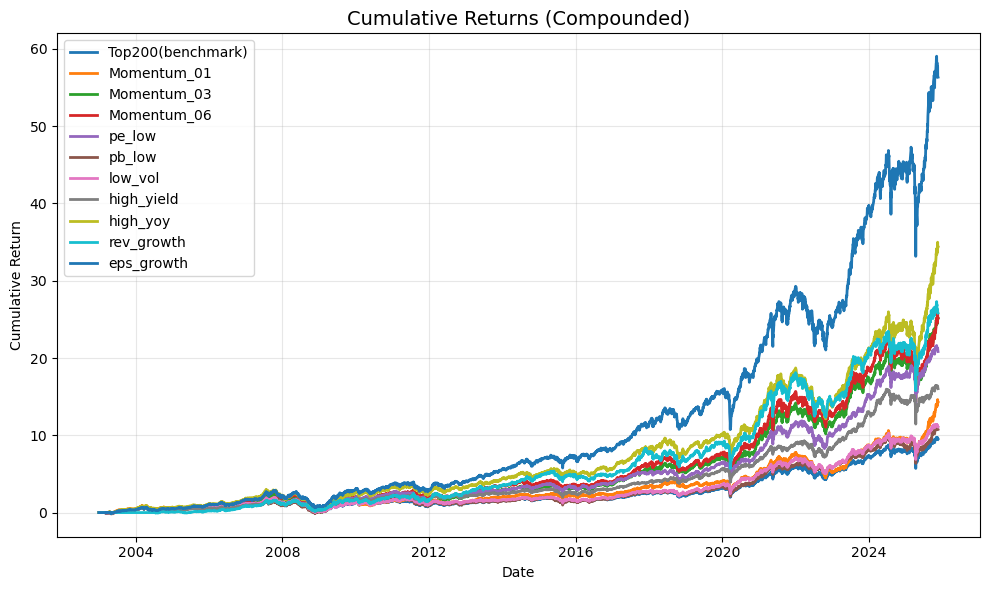

In [9]:
import matplotlib.pyplot as plt

def plot_cum_returns(*series, labels=None, title="Cumulative Returns (Compounded)"):
    """
    輸入一個或多個 return series，畫複利累積報酬
    series: 每個是 pd.Series (index=日期, values=日報酬)
    labels: 對應的名稱
    
    """
    plt.figure(figsize=(10, 6))
    
    for i, s in enumerate(series):
        cum = (1 + s).cumprod() - 1
        label = labels[i] if labels else f"Series {i+1}"
        plt.plot(cum.index, cum.values, label=label, linewidth=2)
    
    plt.title(title, fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

ret_top200      = alpha_sector_neutral_return(top200_alpha,      returns, sector_map, sector_weight_monthly)
ret_mom         = alpha_sector_neutral_return(momentum_01_alpha, returns, sector_map, sector_weight_monthly)
ret_mom3        = alpha_sector_neutral_return(momentum_03_alpha, returns, sector_map, sector_weight_monthly)
ret_mom6        = alpha_sector_neutral_return(momentum_06_alpha, returns, sector_map, sector_weight_monthly)
ret_pe_low1     = alpha_sector_neutral_return(pe_low_01_alpha,   returns, sector_map, sector_weight_monthly)
ret_pb_low1     = alpha_sector_neutral_return(pb_low_01_alpha,   returns, sector_map, sector_weight_monthly)
ret_low_vol     = alpha_sector_neutral_return(low_vol_alpha,     returns, sector_map, sector_weight_monthly)
ret_high_yield  = alpha_sector_neutral_return(high_yield_alpha,  returns, sector_map, sector_weight_monthly)
ret_high_yoy    = alpha_sector_neutral_return(high_yoy_alpha,    returns, sector_map, sector_weight_monthly)  # lag 兩個月邏輯仍在 alpha 內
ret_rev_growth  = alpha_sector_neutral_return(sig_margin,        returns, sector_map, sector_weight_monthly)
ret_eps_growth  = alpha_sector_neutral_return(eps_up,            returns, sector_map, sector_weight_monthly)

plot_cum_returns(ret_top200, ret_mom,ret_mom3,ret_mom6,ret_pe_low1,ret_pb_low1,ret_low_vol,ret_high_yield,ret_high_yoy,ret_rev_growth,ret_eps_growth,labels=["Top200(benchmark)", "Momentum_01","Momentum_03","Momentum_06","pe_low","pb_low","low_vol","high_yield","high_yoy","rev_growth","eps_growth"])


In [12]:
import pandas as pd
import numpy as np

def perf_summary(returns_dict: dict, freq: int = 252, rf: float = 0.0) -> pd.DataFrame:
    """
    統整策略績效：年化報酬、年化波動率、Sharpe ratio
    
    returns_dict: dict[str, pd.Series] {策略名稱: 日報酬序列}
    freq: 一年交易日數 (預設 252)
    rf: 無風險利率 (日化)，預設 0
    
    回傳：pd.DataFrame
    """
    rows = []
    for name, r in returns_dict.items():
        r = r.dropna()
        ann_ret = (1 + r).prod() ** (freq / len(r)) - 1
        ann_vol = r.std() * np.sqrt(freq)
        sharpe = (ann_ret - rf) / ann_vol if ann_vol > 0 else np.nan
        rows.append([ann_ret, ann_vol, sharpe])
    
    return pd.DataFrame(rows, index=returns_dict.keys(),
                        columns=["Annual Return", "Annual Volatility", "Sharpe Ratio"])

# ---------------- 使用範例 ----------------
perf_table = perf_summary({
    "Momentum_01": ret_mom,
    "Momentum_03": ret_mom3,
    "Momentum_06": ret_mom6,
    "PE_low": ret_pe_low1,
    "PB_low": ret_pb_low1,
    "Low_vol": ret_low_vol,
    "High_yield": ret_high_yield,
    "High_yoy": ret_high_yoy,
    "Rev_growth": ret_rev_growth,
    "eps_growth": ret_eps_growth,
    "benchmark":ret_top200
})

perf_table.sort_values(by="Annual Return")


,Annual Return,Annual Volatility,Sharpe Ratio
benchmark,0.110841,0.197492,0.561243
PB_low,0.116578,0.204991,0.568700
Low_vol,0.117915,0.198193,0.594948
Momentum_01,0.129662,0.205457,0.631091
High_yield,0.135208,0.177462,0.761899
PE_low,0.147885,0.198975,0.743235
Momentum_03,0.157074,0.209909,0.748294
Momentum_06,0.157144,0.212129,0.740793
Rev_growth,0.158496,0.209337,0.757134
High_yoy,0.172923,0.211742,0.816666


In [13]:
import interval_report
importlib.reload(interval_report)

from interval_report import perf_report,factor_monthly_heatmap_plotly,factor_rank_tile,factor_rank_tile_full

## 函數1:指定區間因子報酬報表

c:\Users\USER\OneDrive\桌面\因子投資_ver1\interval_report.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(perf_table_sorted.index, rotation=30, ha="right")


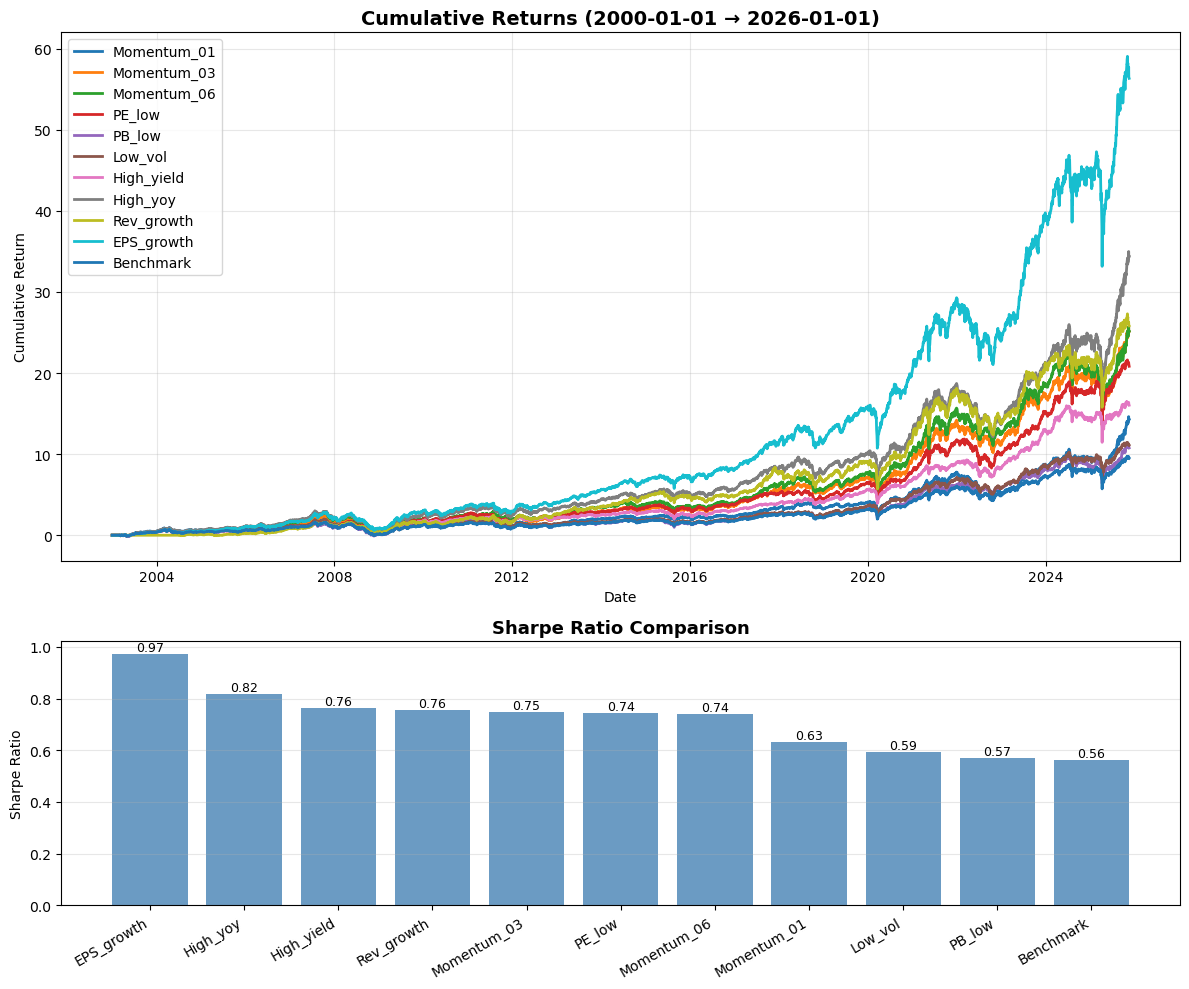

             Annual Return  Annual Volatility  Sharpe Ratio  Total Return
Momentum_01         0.1297             0.2055        0.6311       14.2679
Momentum_03         0.1571             0.2099        0.7483       25.0958
Momentum_06         0.1571             0.2121        0.7408       25.1312
PE_low              0.1479             0.1990        0.7432       20.8354
PB_low              0.1166             0.2050        0.5687       10.7669
Low_vol             0.1179             0.1982        0.5949       11.0859
High_yield          0.1352             0.1775        0.7619       16.0346
High_yoy            0.1729             0.2117        0.8167       34.3726
Rev_growth          0.1585             0.2093        0.7571       25.8225
EPS_growth          0.1985             0.2039        0.9737       56.3363
Benchmark           0.1108             0.1975        0.5612        9.4868


In [14]:
factors = {
    "Momentum_01": ret_mom,
    "Momentum_03": ret_mom3,
    "Momentum_06": ret_mom6,
    "PE_low": ret_pe_low1,
    "PB_low": ret_pb_low1,
    "Low_vol": ret_low_vol,
    "High_yield": ret_high_yield,
    "High_yoy": ret_high_yoy,
    "Rev_growth": ret_rev_growth,
    "EPS_growth": ret_eps_growth,
    "Benchmark" : ret_top200
}


start= "2000-01-01"
end= "2026-01-01"

# start= "2021-01-01"
# end= "2025-05-01"


report = perf_report(factors, start_date=start, end_date=end)
print(report.round(4))


## 函數2:最近一年因子月表現熱力圖

In [15]:
returns_dict = {
    "Momentum_01": ret_mom,
    
    "Momentum_06": ret_mom6,
    "PE_low": ret_pe_low1,
    "PB_low": ret_pb_low1,
    "Low_vol": ret_low_vol,
    "High_yield": ret_high_yield,
    "High_yoy": ret_high_yoy,
    "Rev_growth": ret_rev_growth,
    "EPS_growth": ret_eps_growth,
    
}

_ = factor_rank_tile_full(
    returns_dict=returns_dict,
    periods=12,
    freq="M",                   # "M" / "W" / "Y"
    
    text_size=8,              
    # save_html="factor_rank_last12_months.html",
)


c:\Users\USER\OneDrive\桌面\因子投資_ver1\interval_report.py:312: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ret_p = (1 + r).resample(freq).prod() - 1
c:\Users\USER\OneDrive\桌面\因子投資_ver1\interval_report.py:337: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Z = pivot_factor.replace(factor_code).to_numpy()


##### 

In [16]:
# internship、project detail，including github clear

# come up with reasearch plan

# grad school course plan

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ email to prof manager

# motivation 

# conclusion 





# 函數3: 當日持股明細

In [17]:
def porfolio_list(alpha,date):
    return alpha.columns[(alpha.loc[date]==1)]

In [18]:
(porfolio_list(pe_low_01_alpha,"2025-11-13"))

Index(['1102', '1210', '1215', '2006', '2206', '2303', '2313', '2324', '2347',
       '2357', '2376', '2377', '2379', '2382', '2385', '2458', '2474', '2504',
       '2539', '2603', '2606', '2609', '2610', '2615', '2618', '2801', '2834',
       '2855', '2881', '2882', '2891', '2915', '3005', '3008', '3023', '3034',
       '3036', '3044', '3260', '3406', '3596', '3702', '4915', '4938', '5434',
       '5522', '5871', '5876', '6121', '6147', '6176', '6257', '6285', '6412',
       '6414', '6670', '9904', '9939', '9941', '9945'],
      dtype='object')